In [7]:
import pandas as pd
import glob

# List of file paths for the CSV datasets
file_paths = glob.glob("../data/who_dataset/*.csv")  # Replace with the actual folder path

# Load and concatenate the datasets into a single DataFrame
dataframes = [pd.read_csv(file) for file in file_paths]
df = pd.concat(dataframes, ignore_index=True)

# Display the first few rows to verify the merged datasets
print(df.head())

# Save the unified datasets to a new CSV file (optional)
df.to_csv("../data/who_dataset/merged_dataset.csv", index=False)

                                    meal_description       carb    protein  \
0  For my midday meal, I had a delightful 84g ser...   9.567600   2.427600   
1  For a quick snack, I had 45g of wheat crackers...  82.283000  10.423000   
2  For my snack, I indulged in 132g of delicious ...  37.224000   5.016000   
3  At dinner, I served myself 46.25g of white ric...  37.411625   3.473375   
4  I savored 15g of mustard during dinner, which ...   0.795000   0.637500   

         fat   energy  
0   0.285600   42.840  
1  19.187000  540.850  
2  14.520000  285.120  
3   0.476375  172.975  
4   0.507000   10.350  


In [8]:
from sklearn.preprocessing import MinMaxScaler

dataset_name = "merged_dataset.csv"

df = pd.read_csv("../data/who_dataset/" + dataset_name)

df_pt = pd.read_csv("../data/insa_dataset/processed_nutri_data.csv")

df = pd.concat([df, df_pt], ignore_index=True)


In [9]:
from word2number import w2n
import re

def convert_fractions(text):
    fraction_map = {
        'half': 0.5,
        'quarter': 0.25,
        'third': 1/3,
        'three quarters': 0.75,
        'two thirds': 2/3
    }

    # Trata "one and a half", etc.
    pattern = r'(\w+)\s+and\s+a?\s*(half|quarter|third|three quarters|two thirds)'
    matches = re.finditer(pattern, text)
    for match in matches:
        try:
            whole = w2n.word_to_num(match.group(1))
            frac = fraction_map.get(match.group(2))
            if frac:
                total = whole + frac
                text = text.replace(match.group(0), str(total))
        except ValueError:
            continue  # Se não for um número válido, ignora

    # Trata "half", "quarter" isolados
    for word, value in fraction_map.items():
        text = re.sub(rf'\b{word}\b', str(value), text)

    return text

def convert_special_terms(text):
    special_numbers = {
        "single": 1,
        "double": 2,
        "triple": 3,
        "quadruple": 4,
        "quintuple": 5,
        "sextuple": 6
    }

    for word, num in special_numbers.items():
        text = re.sub(rf'\b{word}\b', str(num), text)
    return text

def convert_numbers(text):
    text = convert_fractions(text)
    text = convert_special_terms(text)

    words = text.split()
    converted = []
    for word in words:
        try:
            if re.match(r'^[a-zA-Z\-]+$', word):  # tenta apenas em palavras tipo "two", "thirty-three"
                num = w2n.word_to_num(word)
                converted.append(str(num))
            else:
                converted.append(word)
        except ValueError:
            converted.append(word)
    return ' '.join(converted)

def clean_meal_description(text):
    text = text.lower()
    text = convert_numbers(text)
    text = re.sub(r'[^\w\s/]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def normalize_units(text):
    text = re.sub(r'\bgrams?\b', 'g', text)
    text = re.sub(r'\bkilograms?\b', 'kg', text)
    text = re.sub(r'\bmilliliters?\b', 'ml', text)
    text = re.sub(r'\bliters?\b', 'l', text)
    text = re.sub(r'\btablespoons?\b', 'tbsp', text)
    text = re.sub(r'\bteaspoons?\b', 'tsp', text)
    return text

def convert_inline_fractions(text):
    # Ex.: "1/2" -> "0.5"
    text = re.sub(r'\b(\d+)/(\d+)\b', lambda m: str(round(int(m.group(1)) / int(m.group(2)), 2)), text)
    return text

def remove_noise(text):
    # Padrões regulares
    noise_patterns = [
        # Frases temporais e contextuais
        r'\b(for|at|during|in the|my)\s+(breakfast|lunch|dinner|snack|afternoon|evening|morning|meal|day)\b',
        r'\bthis\s+(morning|evening|afternoon|snack|day|midday)\b',
        r'\btoday\b',
        r'\bto start my (day|morning)\b',
        r'\bi kicked off my day\b',
        r'\bi\s+(had|enjoyed|savored|prepared|nibbled|relished|consumed|started|opted for|treated myself|made)\b',

        # Ligações e descrições desnecessárias
        r'\b(a touch of|a sprinkle of|combined with|alongside|enhanced with|featuring|designed to|just a|for a|for my)\b',
        r'\bperfect for\b',
        r'\bseasoned with\b',
        r'\btopped with\b',
        r'\bto bring out\b',
        r'\bto enhance\b',
        r'\bwhich was\b',
        r'\bthat was\b',
    ]

    # Palavras soltas adicionais para remover
    noise_words = [
        "delightful", "quick", "snack", "indulged", "simple", "hearty",
        "tonights", "dinner", "light", "conforting", "refreshing",
        "flavorful", "tasty", "savory", "sweet", "nutritious", "perfect", "midday","for","served","myself","day","morning","evening","afternoon","snack","meal","lunch","breakfast","dinner","opted","prepared","enjoyed","savored","nibbled","relished","consumed","started","treated","made","kicked","off","start","today","during","in","the","at","to","with","a","of","and","or","was","which","that","just","sprinkle","combined","alongside","enhanced","featuring","designed","touch","topped","bring","out","enhance","perfect","seasoned","topped","which","that","was","a","for","my","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had", "small", "portion", "comforting", "delicious","included","time", "on", "featured", "serving","munched",
        "consisted","deliciously", "kick","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","grabbed","a","bite","to","eat","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start","my","day","i","kicked","off","my","day","i","had","enjoyed","savored","prepared","nibbled","relished","consumed","started","opted","for","treated","myself","made","today","to","start","my","day","this","morning","evening","afternoon","snack","day","to","start", "warm","tonight", "satisfying","added","wrapped up", "s", "cozy", "rounded", "midmorning", "unique", "snacked", "took", "little", "pickmeup", "dose", "hint", "boost", "as", "smooth", "consisting", "wholesome", "creamy","colorful", "spread", "healthy", "sure", "an", "fresh", "freshly", "interesting", "tide", "me", "over", "while", "snacking", "vibrant", "provided", "whole", "enjoying", "squezzed", "reached", "generous", "portion", "satisfying","sipped", "casual", "break", "cool", "decided", "combination", "freshly", "made", "chewy", "crunchy", "crispy", "crunchy", "drank", "brunch", "lunchtime", "succulent", "generous", "juicy", "fulfilling","quite",
        "rich", "thirstquenching", "routine"
    ]

    # Aplica regex nos padrões complexos
    for pattern in noise_patterns:
        text = re.sub(pattern, '', text)

    # Remove palavras isoladas
    for word in noise_words:
        text = re.sub(rf'\b{word}\b', '', text)

    # Limpeza final de espaços extras
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def add_region_tag(text, region="usa"):
    if(text.find("region") != -1):
        return text
    return f"region: {region} {text}"

def full_clean_pipeline(text):
    text = text.lower()
    text = convert_numbers(text)  # a função que você já tem para "two" -> "2" etc.
    text = convert_inline_fractions(text)
    text = normalize_units(text)
    text = remove_noise(text)
    text = add_region_tag(text, region="usa")
    text = re.sub(r'[^\w\s/]', '', text)  # remove pontuação, mantendo '/' se necessário
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


df["meal_description"] = df["meal_description"].apply(full_clean_pipeline)


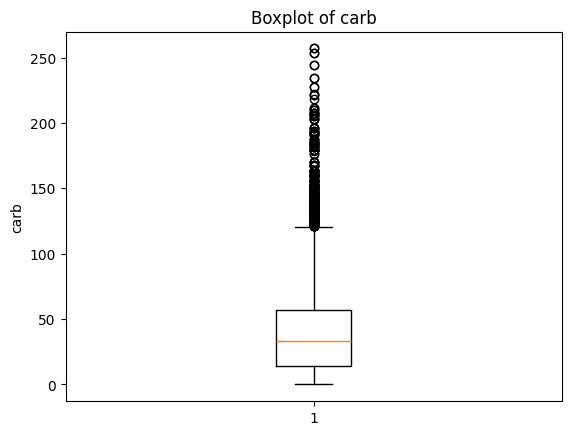

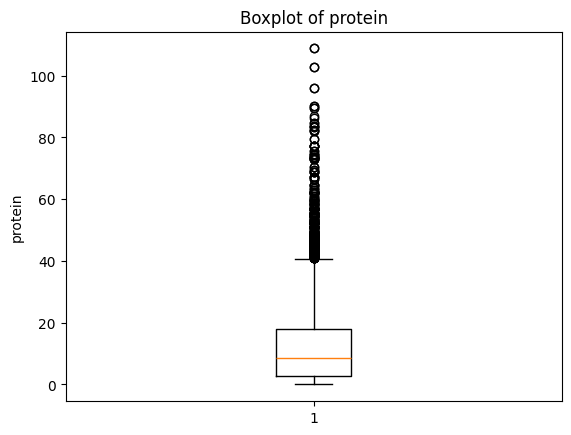

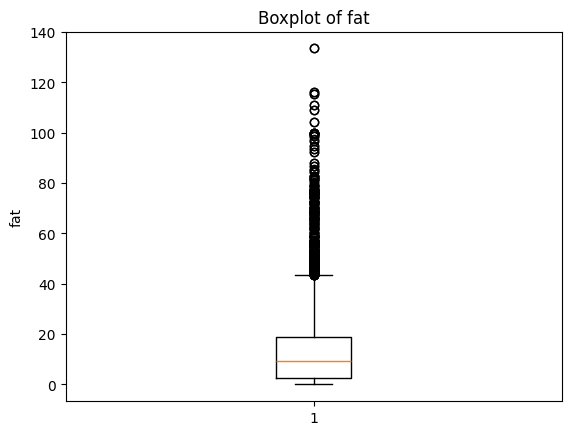

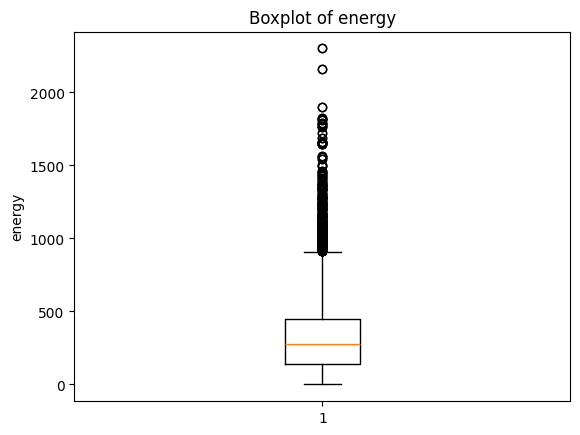

Outliers in 'carb': 350
Outliers in 'protein': 365
Outliers in 'fat': 444
Outliers in 'energy': 405


In [10]:
import matplotlib.pyplot as plt

for col in ["carb", "protein", "fat", "energy"]:
    plt.figure()
    plt.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Exemplo para carbs
outliers_carb = detect_outliers_iqr(df, "carb")
outliers_protein = detect_outliers_iqr(df, "protein")
outliers_fat = detect_outliers_iqr(df, "fat")
outliers_energy = detect_outliers_iqr(df, "energy")

print(f"Outliers in 'carb': {len(outliers_carb)}")
print(f"Outliers in 'protein': {len(outliers_protein)}")
print(f"Outliers in 'fat': {len(outliers_fat)}")
print(f"Outliers in 'energy': {len(outliers_energy)}")

In [11]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

cols = ["carb", "protein", "fat", "energy"]
df_clean = remove_outliers_iqr(df, cols)
print(f"Original: {df.shape[0]} linhas")
print(f"Após remoção de outliers: {df_clean.shape[0]} linhas")

Original: 13187 linhas
Após remoção de outliers: 12176 linhas


In [12]:
# Define the columns to be normalized
columns_to_normalize = ["carb", "protein", "fat", "energy"]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the specified columns
df_clean[columns_to_normalize] = scaler.fit_transform(df_clean[columns_to_normalize])

# Display the first few rows to verify the normalization
print(df_clean.head())

# Save the normalized datasets to a new CSV file (optional)
df_clean.to_csv("../data/who_dataset/normalized/normalized_"+dataset_name, index=False)

import joblib

joblib.dump(scaler, "../data/who_dataset/pickle/scaler_merged_dataset.pkl")

                                    meal_description      carb   protein  \
0  region usa 84g cooked artichokes boiled sprink...  0.079314  0.061865   
1  region usa 45g wheat crackers paired 80g dry m...  0.682111  0.265622   
2                region usa 132g chocolate ice cream  0.308580  0.127829   
3  region usa 4625g white rice specifically longg...  0.310135  0.088516   
4                  region usa 15g mustard nice plate  0.006590  0.016246   

        fat    energy  
0  0.006865  0.052409  
1  0.461226  0.661655  
2  0.349038  0.348805  
3  0.011451  0.211611  
4  0.012187  0.012662  


['../data/who_dataset/pickle/scaler_merged_dataset.pkl']